# Little Miami River, Ohio

## Trends in flashiness of streamflow and precipitation

Sources:
https://www.earthdatascience.org/tutorials/acquire-and-visualize-usgs-hydrology-data/

https://github.com/sativa/hydro-1

http://climata.houstoneng.net/

For selecting USGS stations and available data, see

https://maps.waterdata.usgs.gov/mapper/

Build a Pandas dataframe with datetime index and columns for streamflow and precipitation, choosing one or more precipitation stations that are well located within the watershed above the stream gauge.




In [1]:
#basic imports
import matplotlib.pyplot as plt
from climata.usgs import DailyValueIO
from climata.acis import StationDataIO
import pandas as pd
import numpy as np
import folium  #folium on Jupyter doesn't do well in Microsoft Edge. Chrome works.
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 9]

In [2]:
#some functions
def flashiness(series):
    """Richards-Baker Flashiness Index for a Pandas series of daily mean flows = the path length divided by the sum."""
    Qsum = np.sum(series)  # sum of daily flows
    # the path length, or sum of differences between adjacent daily flows:
    Qpath = np.sum(pd.Series(np.abs(series.shift(1)-series))) 
    return round(Qpath/Qsum,2)
    

def flow_duration(series):
    """Returns a Pandas series, a flow duration curve, whose index is the flow values and series is the frequency of exceeding a given flow."""
    fd = pd.Series(series).value_counts()               # frequency of unique values
    fd.sort_index(inplace=True)                         # sort in order of increasing flows
    fd = fd.cumsum()                                    # cumulative sum of frequencies
    fd = fd.apply(lambda x: 1 - x/fd.max())             # normalize from 0 to 1
    return fd

## Streamflow
This river runs into the Ohio. HUC 8 code for Little Miami: 05090202. 1757 sq miles. Using the USGS water explorer, the gauge at Milford (03245500) starts recording in 1915-10-01.

Caesar Creek Lake was created by an Army Corps dam in 1973 on Caesar Creek, a tributary of the main stem.
Harsha Lake on the East Fork was created in 1977 by a dam.


In [3]:
startdate = "1915-10-01"
enddate = "2019-02-16"
param_id = "00060" #stream flow in cfs
data = DailyValueIO(
    start_date=startdate,
    end_date=enddate,
    basin="05090202", #Little Miami upper basin
    #station=station_id,
    parameter=param_id,
)
list(data)

[DailyValueIOTuple(site_name='Little Miami River near Selma OH', site_code='03239000', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=39.81006018, longitude=-83.7390913, data=<climata.parsers.TimeSeriesIO object at 0x0000022354F804E0>),
 DailyValueIOTuple(site_name='North Fork Little Miami River near Pitchin OH', site_code='03239500', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=39.82783787, longitude=-83.7771482, data=<climata.parsers.TimeSeriesIO object at 0x00000223550E0E10>),
 DailyValueIOTuple(site_name='Little Miami River near Oldtown OH', site_code='03240000', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=39.74839296, longitude=-83.9313196, data=<climata.parsers.TimeSeriesIO object at 0x00000223550E0E48>),
 DailyValueIOTuple(site_name='North Fork Massie Creek at Cedarville OH', site_code='03240500', variable_name='Streamflow, ft&#179;/s', variable_code='00060',

In [4]:
#make dataframe with nested list comprehension
flows = pd.DataFrame([[y for y in x] for x in data], columns=['name','code','variable_name','variable_code','unit','lat','lon','data'])
starts = []
ends = []
flash = []
#add start and end dates, flashiness for flow data
for site in data:
    starts.append(site.data[0][0]) #the first date in the tuple
    ends.append(site.data[-1][0]) #the last date in the tuple
    flash.append(flashiness(pd.Series([r[1] for r in site.data]))) #run flashiness on flow data
flows['start'] = starts
flows['end'] = ends
flows['flash'] = flash
flows.describe()
#.strftime('%Y-%m-%d')

,lat,lon,flash
count,26.000000,26.000000,26.000000
mean,39.418676,-84.007384,0.584615
std,0.266002,0.178102,0.198821
min,39.027842,-84.352995,0.300000
25%,39.145616,-84.122990,0.450000
50%,39.443812,-84.019238,0.530000
75%,39.619158,-83.852188,0.715000
max,39.827838,-83.739091,1.050000


In [7]:
#map the flow gauges and the total flashiness for their run of data
m = folium.Map(location=[flows['lat'].mean(), flows['lon'].mean()], zoom_start=9, tiles="Stamen Terrain")

logs = 'https://storage.googleapis.com/logs1tiles/LittleMiami/{z}/{x}/{y}'
m.add_tile_layer(tiles=logs, attr="computed with Earth Engine", name='length of green')
def style_function(feature):
    return {
        'fillOpacity': 0,
        'weight': 2,
        'color':'red'
        }


ohioHUC8 = 'ohioHUC8.json'    
folium.GeoJson(
    ohioHUC8,
    name='HUC8',
    style_function=style_function,
    ).add_to(m)

folium.LayerControl().add_to(m)

for i in range(0,len(flows)):
    fl= flows.iloc[i]['flash']
    if fl > .73:
        color = 'red'
    elif fl < .45:
        color = 'blue'
    else:
        color = 'lightred'
#     popup = fl
    popup = flows.iloc[i]['start'].strftime('%Y-%m-%d')+' : '+flows.iloc[i]['end'].strftime('%Y-%m-%d')+'<br>RB flashiness: <b>' + str(flows.iloc[i]['flash'])+'</b>'
    tooltip = flows.iloc[i]['name']+'<br>Station: '+flows.iloc[i]['code']
    icon = folium.Icon(color=color, prefix='fa',icon='tachometer')
    folium.Marker([flows.iloc[i]['lat'], flows.iloc[i]['lon']],popup=popup,tooltip=tooltip,icon=icon).add_to(m)
m

In [18]:
#make dataframe from Milford, Perintown
lm = DailyValueIO(
    start_date='1915-10-01',
    end_date='2019-02-14',
    station="03245500",
    parameter="00060"
)
ef = DailyValueIO(
    start_date='1915-10-01',
    end_date='2019-02-14',
    station="03247500",
    parameter="00060"
)
list(ef)

[DailyValueIOTuple(site_name='East Fork Little Miami River at Perintown OH', site_code='03247500', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=39.13700548, longitude=-84.2379918, data=<climata.parsers.TimeSeriesIO object at 0x0000027950AC2F98>)]

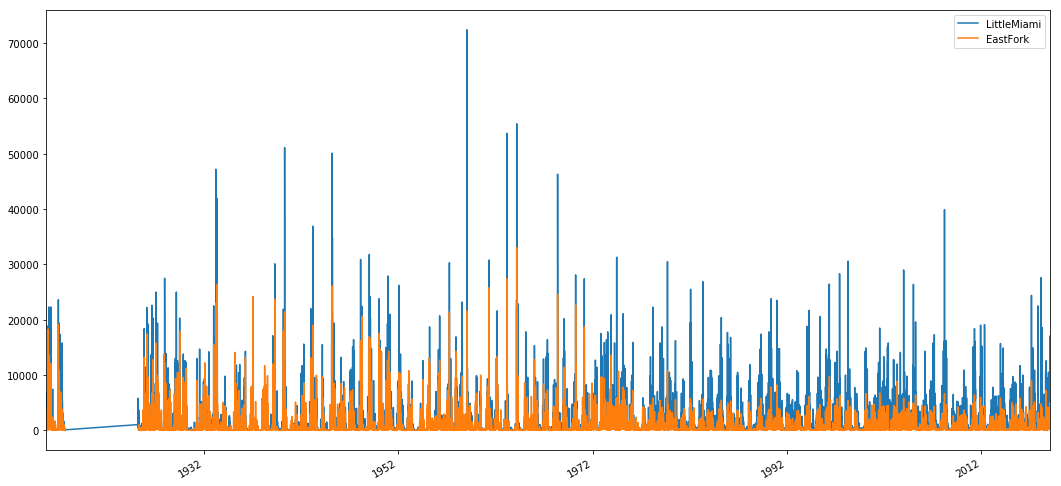

In [202]:
#after some inspection of the returned object, this is what we need:
dates = [r[0] for r in ef[0][7]]
flows = [r[1] for r in ef[0][7]]
f1 = pd.DataFrame(flows,index=dates, columns=['EastFork'])
dates = [r[0] for r in lm[0][7]]
flows = [r[1] for r in lm[0][7]]
f2 = pd.DataFrame(flows,index=dates, columns=['LittleMiami'])
lmflows = pd.concat([f2,f1],axis=1)
lmflows.index = pd.to_datetime(lmflows.index)        
lmflows.plot()

In [ ]:
#This shows a gap in the records until about April 1925.
lmflows=lmflows['1925-04-01':'2019-02-16']

## Precipitation

In [47]:
#what are available precipitation gauges in the basin for our date range?
pdata = StationDataIO(
    start_date='1925-04-01',
    end_date='2019-02-16',
    basin="05090202", 
#     county='06069',
    parameter="pcpn",
)
list(pdata) 

[StationDataIOTuple(name='CINCINNATI MOUNT WASHINGTON', sids={'COOP': '335590', 'GHCN': 'USC00335590'}, county='39061', state='OH', elev=751.0, climdiv='OH07', uid=14357, longitude=-84.38333, latitude=39.08333, data=<climata.acis.DataIO object at 0x0000027919D35588>),
 StationDataIOTuple(name='CINCINNATI AULT PARK', sids={'COOP': '331566', 'GHCN': 'USC00331566'}, county='39061', state='OH', elev=771.0, climdiv='OH08', uid=14365, longitude=-84.41667, latitude=39.13333, data=<climata.acis.DataIO object at 0x0000027963BAA6A0>),
 StationDataIOTuple(name='CINCINNATI MUNICIPAL AP LUNKEN FIELD', sids={'WBAN': '93812', 'COOP': '331576', 'FAA': 'LUK', 'ICAO': 'KLUK', 'GHCN': 'USW00093812', 'NWSLI': 'LUK'}, county='39061', state='OH', elev=490.0, climdiv=None, uid=14366, longitude=-84.41889, latitude=39.10333, data=<climata.acis.DataIO object at 0x0000027919D359B0>),
 StationDataIOTuple(name='MADISONVILLE', sids={'COOP': '334824', 'GHCN': 'USC00334824'}, county='39061', state='OH', elev=561.0, c

In [ ]:
#basic dataframe for mapping etc.
precip = pd.DataFrame([[y for y in x] for x in pdata],
columns=['name','codes','county','st','r','a','b','lon','lat','data'])


In [72]:
# create a dataframe of precipitation records
for i in range(0,len(pdata)):
    if i==0:
        dates = [r[0] for r in pdata[i].data]
        pcpn = [r[1] for r in pdata[i].data]
        p = pd.DataFrame(data = pcpn, columns = [pdata[i].name], index=dates)
    else:
        p[pdata[i].name] = [r[1] for r in pdata[i].data]
#make sure it's a datetime index
p.index = pd.to_datetime(p.index)
p.describe()

,CINCINNATI MOUNT WASHINGTON,CINCINNATI AULT PARK,CINCINNATI MUNICIPAL AP LUNKEN FIELD,MADISONVILLE,CINCINNATI OAKLEY,CINCINNATI 5.3 NE,CINCINNATI 6.7 E,WILLIAMSBURG 1 ENE,BATAVIA 4 N,PERINTOWN,...,WILMINGTON 1.6 SSE,BEAVERCREEK 3.2 NE,XENIA 2.1 NNE,BEAVERCREEK 1.5 ENE,FAIRBORN 2.5 SE,CLARKSVILLE 1.3 WNW,BELLBROOK 1.2 NNE,XENIA 4.6 ESE,YELLOW SPRINGS 2.5 ENE,BELLBROOK 1.3 WSW
count,34290,34290,34290.0,34290,34290,34290,34290,34290,34290,34290,...,34290,34290,34290,34290,34290,34290,34290,34290,34290,34290
unique,94,177,266.0,53,159,44,86,162,211,191,...,127,83,78,87,56,39,74,60,69,50
top,M,M,0.0,M,M,M,M,M,M,M,...,M,M,M,M,M,M,M,M,M,M
freq,33445,28739,12166.0,34057,30833,34160,33770,30291,24859,27912,...,32787,34019,33792,33765,34021,34135,33921,34005,33985,34075


In [84]:
#rank these by proportion of 'M' or missing values
a = pd.DataFrame(p.describe())
b = a.transpose()
b['missing']= b['freq']/b['count']
b = b.sort_values('missing')
b = b[0:6]
c = list(b.index)
c

['CINCINNATI MUNICIPAL AP LUNKEN FIELD',
 'WILMINGTON 3 N',
 'KINGS MILLS',
 'WILMINGTON AIRBORNE PARK',
 'MILFORD',
 'XENIA 6 SSE']

In [86]:
p = p[c]
p

,CINCINNATI MUNICIPAL AP LUNKEN FIELD,WILMINGTON 3 N,KINGS MILLS,WILMINGTON AIRBORNE PARK,MILFORD,XENIA 6 SSE
1925-04-01,M,0,0,M,M,0
1925-04-02,M,0,0,M,M,0
1925-04-03,M,0,0,M,M,0
1925-04-04,M,0,0,M,M,0
1925-04-05,M,0,0,M,M,0
1925-04-06,M,0,0,M,M,0
1925-04-07,M,0,0,M,M,0
1925-04-08,M,0,0,M,M,0
1925-04-09,M,0.04,0,M,M,0
1925-04-10,M,0,1.51,M,M,0.5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002796434CDA0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000279807DD588>], dtype=object)

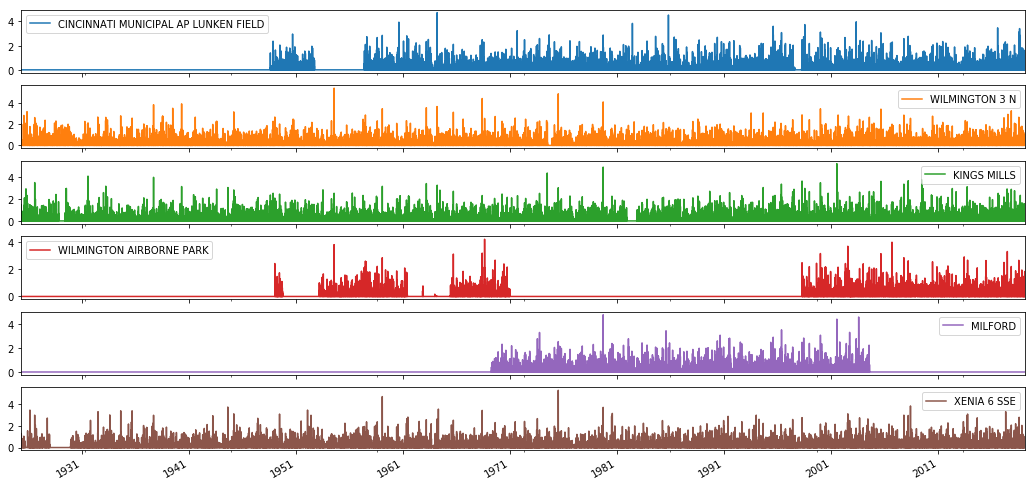

In [87]:
#replace text values so they can be plotted
p.replace(to_replace = ['M','T','S','A'], value=0, regex=True, inplace=True)
p.plot(subplots=True) 

In [122]:
#Wilmington, Kings Mills, and Xenia are the ones to use
mygauges = ['WILMINGTON 3 N', 'KINGS MILLS','XENIA 6 SSE']
p= p[mygauges]

#filter the precip dataframe and map these
precip = precip.loc[precip['name'].isin(mygauges)]

In [140]:
#help(folium.Icon)

In [181]:
m = folium.Map(location=[39.5, -84], zoom_start=10, tiles="Stamen Terrain")

logs = 'https://storage.googleapis.com/logs1tiles/LittleMiami/{z}/{x}/{y}'
def style_function(feature):
    return {
        'fillOpacity': 0,
        'weight': 2,
        'color':'red'
        }
legend_html =   '''
                <div style="position: fixed; background-color: white; 
                            bottom: 10px; left: 10px; width: 120px; height: 60px; 
                            border:2px solid grey; z-index:9999; font-size:12px;">
                            
                            &nbsp; rain gauge &nbsp; <i class="fa fa-cloud fa-2x"></i><br>
                            &nbsp; flow gauge &nbsp; <i class="fa fa-tachometer fa-2x"></i>
                </div>
                ''' 
m.get_root().html.add_child(folium.Element(legend_html))

m.add_tile_layer(tiles=logs, attr="computed with Earth Engine", name='length of green')


ohioHUC8 = 'ohioHUC8.json'    
folium.GeoJson(
    ohioHUC8,
    name='HUC8',
    style_function=style_function,
    ).add_to(m)

for i in range(0,len(precip)):
    folium.Marker([precip.iloc[i]['lat'], precip.iloc[i]['lon']], tooltip=precip.iloc[i]['name'], icon=folium.Icon(color="cadetblue",prefix='fa',icon='cloud')).add_to(m)
# folium.GeoJson(
#     'ohioHUC12small.json',
#     name='simplified HUC12'
# ).add_to(m)
folium.LayerControl().add_to(m)
m

In [190]:
x = pd.Series([1,3,512,34,23,1,23,67,35,456,12,1,0,1,0,1,0])
flashiness(x)

1.711111111111111

# Flashiness
of both streamflow and precipitation.


In [150]:
#flashiness index on the flow
print('RB flashiness of East Fork before dam: ',flashiness(lmflows['1926':'1972']['EastFork']))
print('RB flashiness of East Fork after dam: ',flashiness(lmflows['1974':'2018']['EastFork']))
print('RB flashiness of Little Miami before dam: ',flashiness(lmflows['1940':'1976']['LittleMiami']))
print('RB flashiness of Little Miami after dam: ',flashiness(lmflows['1978':'2017']['LittleMiami']))


RB flashiness of East Fork before dam:  0.804357413104
RB flashiness of East Fork after dam:  0.393969332158
RB flashiness of Little Miami before dam:  0.485423753541
RB flashiness of Little Miami after dam:  0.394604930311


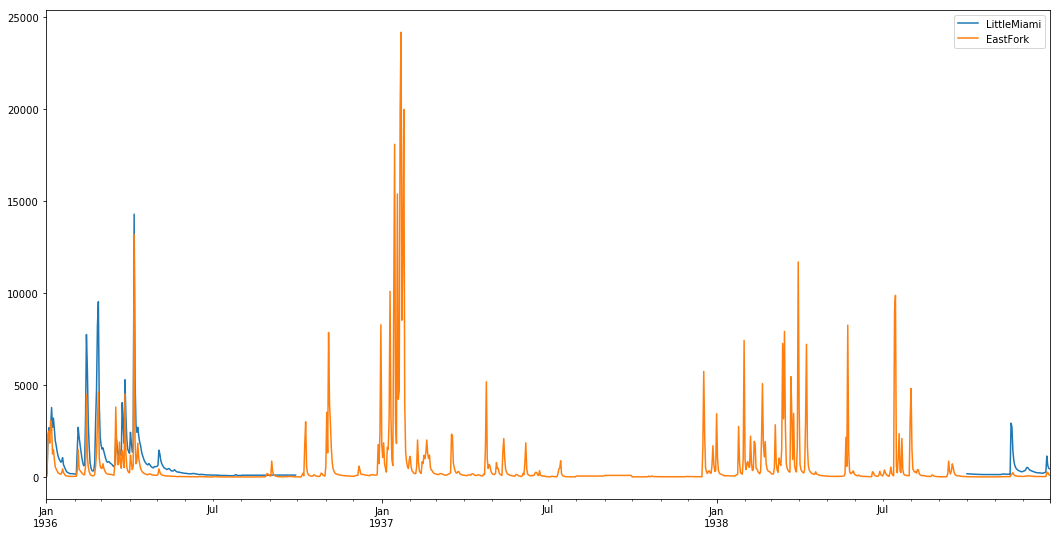

In [102]:
lmflows['1936':'1938'].plot()

In [107]:
lmflows

,LittleMiami,EastFork
1925-04-01,385.0,78.0
1925-04-02,350.0,70.0
1925-04-03,350.0,70.0
1925-04-04,290.0,64.0
1925-04-05,290.0,55.0
1925-04-06,220.0,55.0
1925-04-07,241.0,50.0
1925-04-08,200.0,36.0
1925-04-09,183.0,55.0
1925-04-10,266.0,53.0


In [114]:
p.index = pd.to_datetime(p.index)
lmflows.index = pd.to_datetime(lmflows.index)

In [118]:
# pgroup = p['1930':'2018'].groupby(pd.Grouper(freq='48M')).agg({flashiness})
fgroup = lmflows['1930':'2018'].groupby(pd.Grouper(freq='48M')).agg({flashiness})
fgroup
# flash = pd.concat([pgroup,fgroup], axis=1)
# flash.plot()
# plt.title('Flashiness of precip vs flashiness of river flow in 5-year increments')

,LittleMiami,EastFork
,flashiness,flashiness
1930-01-31,0.419589,0.789524
1934-01-31,0.528393,0.879170
1938-01-31,NaN,0.849162
1942-01-31,NaN,0.878910
1946-01-31,0.559686,0.793558
1950-01-31,0.520446,0.787659
1954-01-31,0.482128,0.758084
1958-01-31,0.510590,0.815186
1962-01-31,0.475974,0.708390


In [117]:
pgroup

,WILMINGTON 3 N,KINGS MILLS,XENIA 6 SSE
,flashiness,flashiness,flashiness
1930-01-31,0.857595,1.069620,1.192748
1934-01-31,1.531191,1.559300,1.630391
1938-01-31,1.528738,1.472006,1.566420
1942-01-31,1.537972,1.524858,1.550961
1946-01-31,1.522186,1.510300,1.614297
1950-01-31,1.483777,1.520643,1.572343
1954-01-31,1.536240,1.574104,1.615923
1958-01-31,1.542684,1.506714,1.575726
1962-01-31,1.504732,1.478276,1.612389


In [16]:
#try some annual figures, sum for precip and mean for flow
precipsums = p['1939-10-01':'2018-09-30'].resample('12M').sum()
flowmeans = sb['1939-10-01':'2018-09-30'].resample('12M').mean()
annual = pd.concat([precipsums, flowmeans], axis=1)
annual['ratio'] = annual['PINNACLES NM']/annual['SBriver']

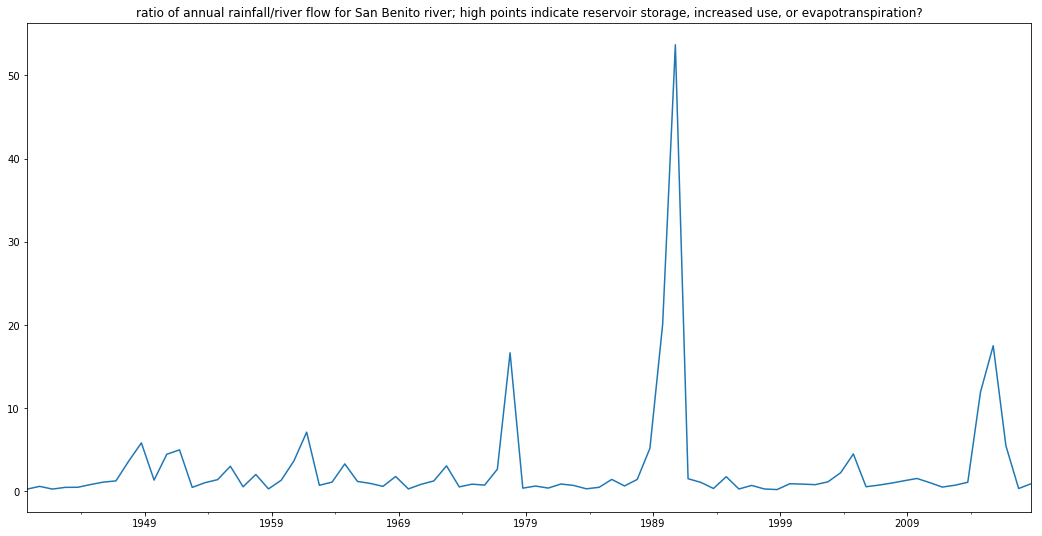

In [17]:
annual.ratio.plot()
plt.title('ratio of annual rainfall/river flow for San Benito river; high points indicate reservoir storage, increased use, or evapotranspiration?')

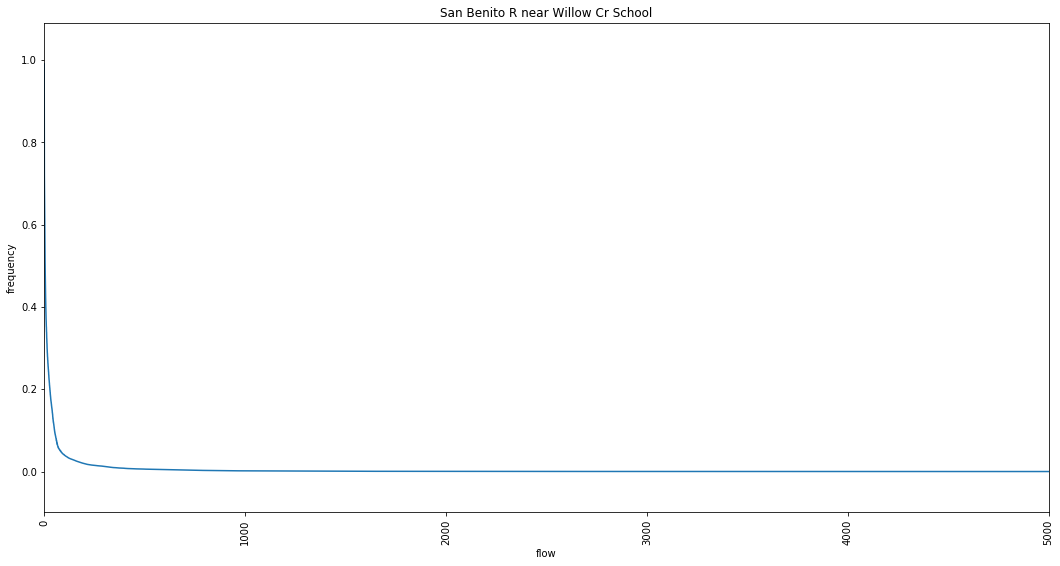

In [18]:
#flow duration curve; this could be rendered in 5-yr periods    
fdc = flow_duration(sb['SBriver'])
fdc.plot()
plt.xlabel('flow')
plt.ylabel('frequency')
plt.title('San Benito R near Willow Cr School')
plt.xticks(rotation='vertical')
plt.margins(.1)
plt.show()

In [219]:
lmflows.to_csv('lmflows.csv')